<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

Определения, используемые в работе
- период - временной отрезок постоянной для всего ряда длины, на концах которого ряд принимает близкие значения,
- сезонность - свойство периодичности (сезон=период),
- тренд - тенденция к долгосрочному увеличению или уменьшению значений ряда.

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import namedtuple

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor

In [2]:
plt.rcParams["figure.figsize"] = (15, 6)
STATE = sum(ord(x) for x in 'NEVER SURRENDER')

_______________________________

Загрузим данные, отсортируем по времени и посмотрим основную информацию.

In [3]:
df_taxi = pd.read_csv('/datasets/taxi.csv', index_col='datetime', parse_dates=['datetime'])

In [4]:
# df_taxi.index.is_monotonic
df_taxi.sort_index(inplace=True)
df_taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Данные загружены, в них содержится информация о заказах такси с марта по август(включительно) 2018 года. Всего 26496 записей, пропущенных значений нет.

Т.к. нам важно предсказание для каждого часа, можно сделать ресемплирование по 1 часу.

In [5]:
df_taxi = df_taxi.resample('1H').sum()

Оценим, какие данные у нас есть:

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


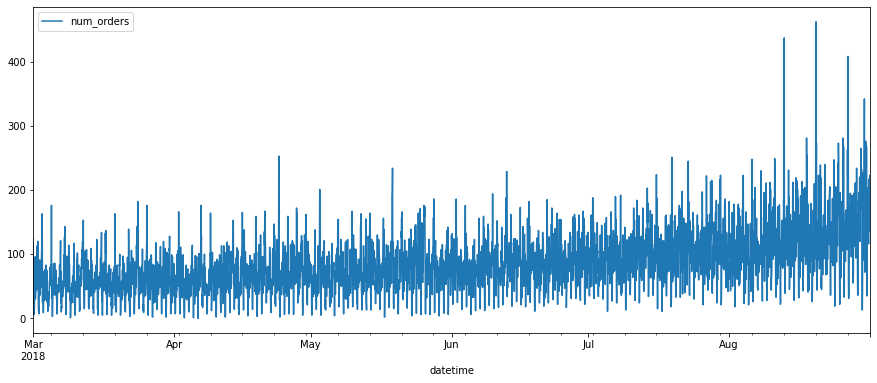

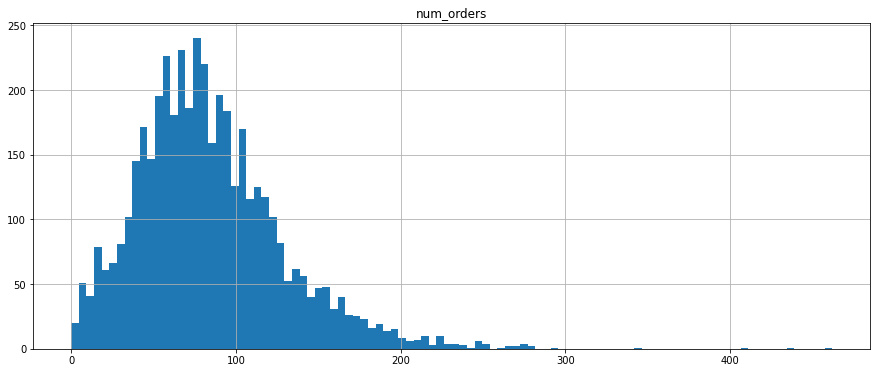

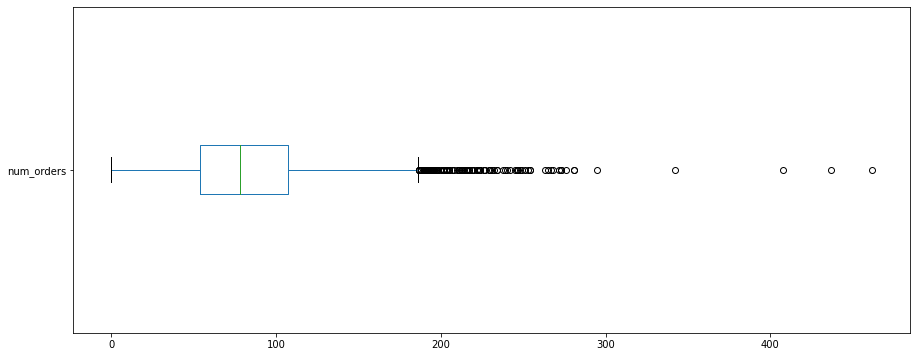

In [6]:
df_taxi.plot()
df_taxi.hist(bins=100)  
df_taxi.plot.box(vert=False);
df_taxi.describe()

Медианное количество заказов 78.

Странным выглядит количество заказов более 280. Возможно, это ошибка данных или повышение спроса, связанное с праздничными днями и пр. Рассмотрим подробнее:

In [7]:
df_taxi.query('num_orders > 280')

,num_orders
datetime,
2018-08-13 02:00:00,437
2018-08-18 00:00:00,281
2018-08-20 02:00:00,462
2018-08-26 00:00:00,281
2018-08-27 02:00:00,408
2018-08-27 04:00:00,295
2018-08-30 17:00:00,342


Можно заметить, что все значения относятся к августу 2018 года, в основном в ночное время. По графику plot можно заметить, что есть тенденция к общему увеличению количества заказов, предварительно будем считать, что все эти значения допустимы и ошибок нет. 

Проверим стационарность ряда по критерию Дики-Фуллера.

In [8]:
adfuller(df_taxi['num_orders'], regression='ctt')

(-10.891452237749158,
 4.0549397892403547e-17,
 31,
 4384,
 {'1%': -4.373775161444573,
  '5%': -3.8337377543683258,
  '10%': -3.554095038926073},
 41625.74040564322)

In [9]:
f"Adfuller p-value {adfuller(df_taxi['num_orders'], regression='ctt')[1]:.4e}"

'Adfuller p-value 4.0549e-17'

**Вывод:** данные были загружены, проведено ресемплирование по 1 часу. Так же проведена предварительная оценка данных.

## Анализ

Автокорреляция позволяет выявлять тренд и сезонность:

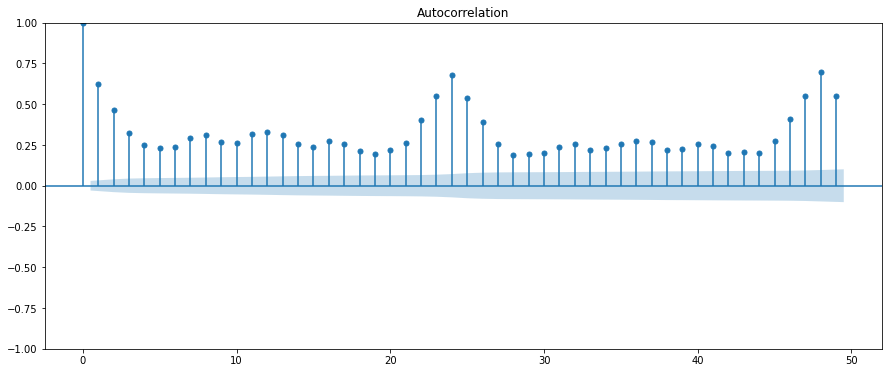

In [10]:
plot_acf(df_taxi, lags=49)
plt.show()

- постоянно положительная корреляция говорит о наличии тренда
- например, заметно, что лаг 24 и 48 выделяются среди остальных и сильнее коррелируют с исходным рядом, чем соседние 23/25 и 47/49. Это позволяет предполагать наличие сезонных колебаний (ежедневных)
- синяя граница помогает оценить значимость корреляции - во всех случаях столбец выходит за пределы, автокорреляция достаточно сильная и ее можно использовать для постоения модели


Попробуем оценить, какой лаг имеет смысл брать для построения модели, построим автокорреляцию для недели (24*7) с шагом в 6 часов

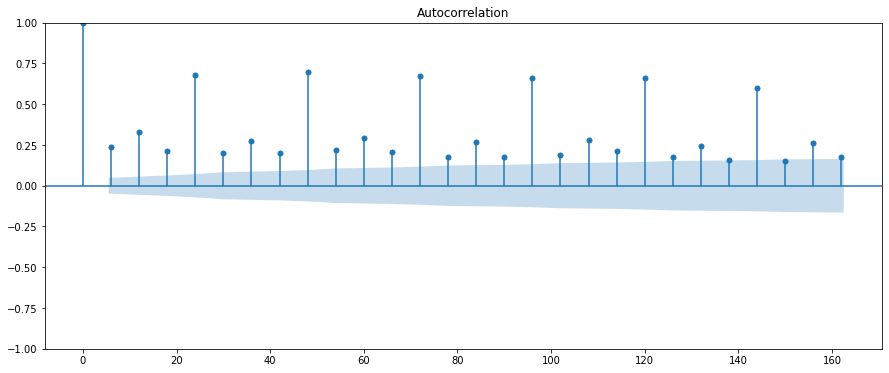

In [11]:
plot_acf(df_taxi, lags=range(0,24*7,6))
plt.show()

По графику видно, что под конец 6 дня появляются значения корреляции, близкие к синей границы. 
_____________________

Так же посмотрим автокорреляцию при ресемплировании на 1 день:

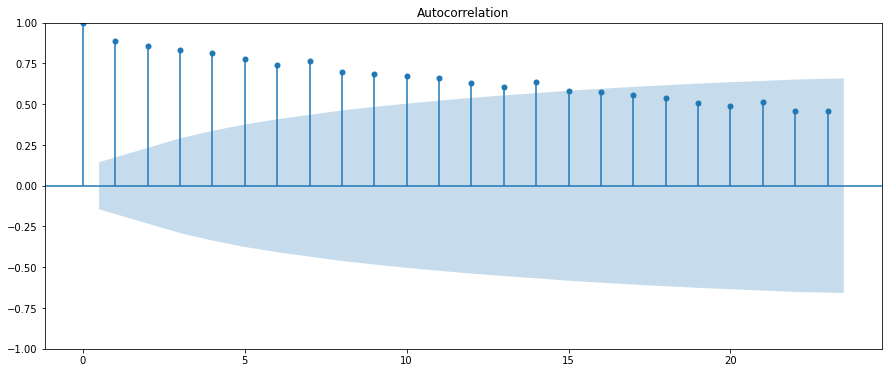

In [12]:
plot_acf(df_taxi.resample('1D').sum())
plt.show()

Можно увидеть, что 7,14, 21 чуть выше соседей, что говорит о наличии еженедельной сезонности.



Рассмотрим подробнее сезонность и выделим необходимые признаки для модели.

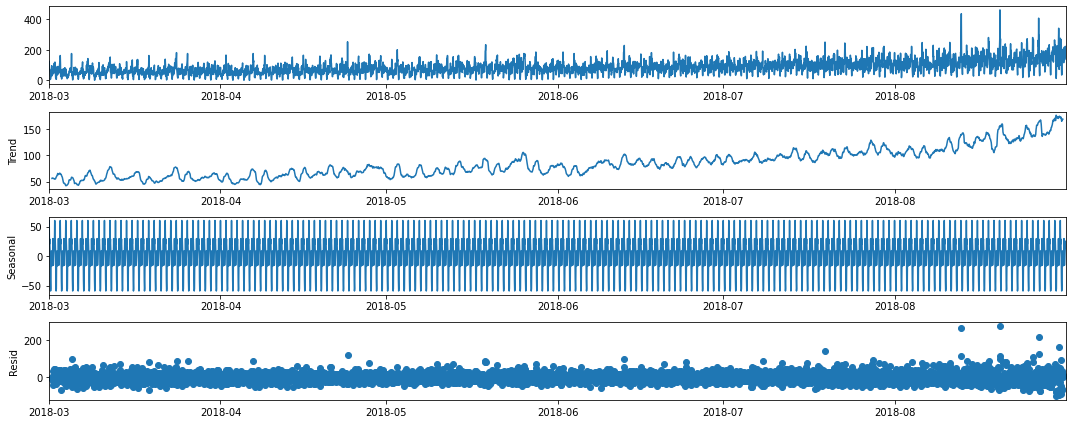

In [13]:
seasonal_decompose(df_taxi).plot();

данные в таком виде анализировать сложно, но можно оценить в тренде, что со временем спрос на такси растет. 

Рассмотрим данные подробнее для месяца и недели:

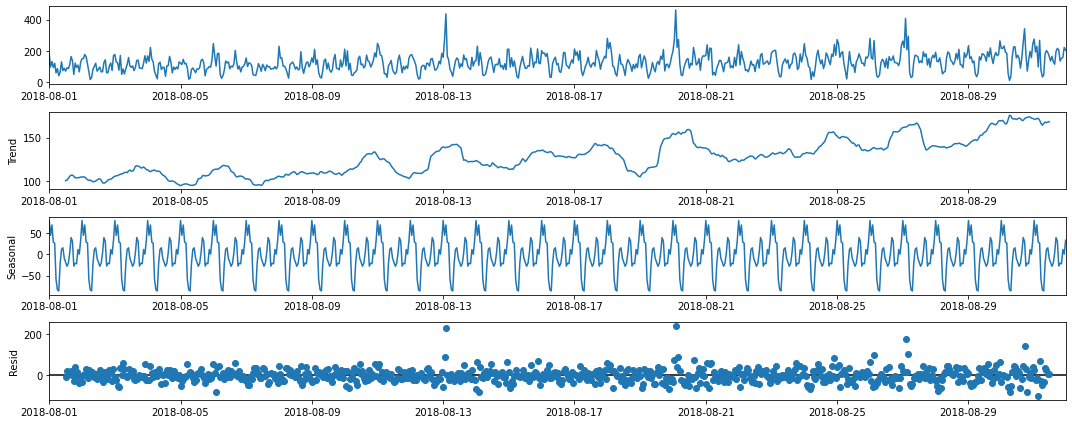

In [14]:
seasonal_decompose(df_taxi['2018-08':]).plot();

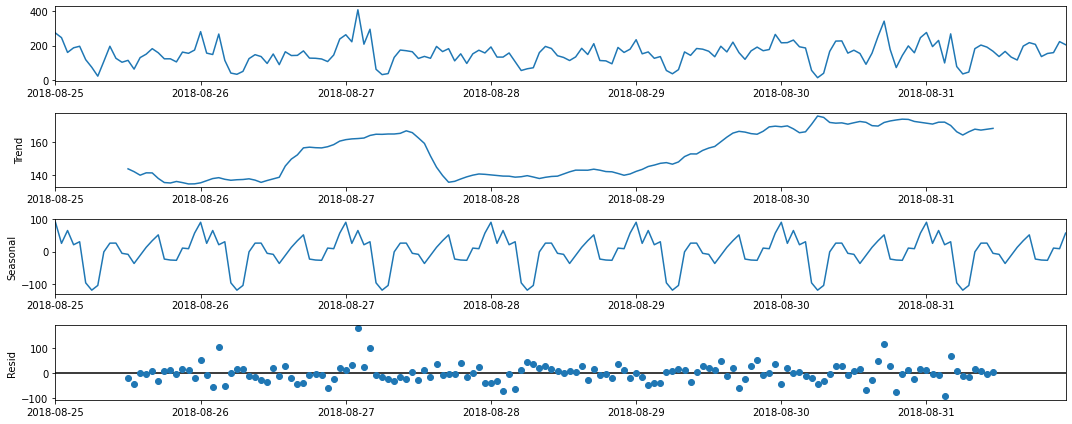

In [15]:
seasonal_decompose(df_taxi['2018-08-25':]).plot();

Можно заметить:
- "пик" в начале дня, потом резкий спад(утренние часы) и вновь активность => **время** будет важным параметром
- изменения линии тренда в зависимости от дня => **день недели** может быть важным параметром


Добавим выделенные признаки в данные

In [16]:
df_taxi['dayofweek'] = df_taxi.index.dayofweek
df_taxi['hour'] = df_taxi.index.hour

Создадим параметры для лагов и скользящего среднего.

Т.к. используется параметр dayofweek, количество лагов можно ограничить значением 24.

In [17]:
for lag in range(1,24): 
    df_taxi[f'lag_{lag}'] = df_taxi['num_orders'].shift(lag)

Скользящее среднее предварительно возьмем по максимальному лагу 24, посмотрим для последнего месяца:

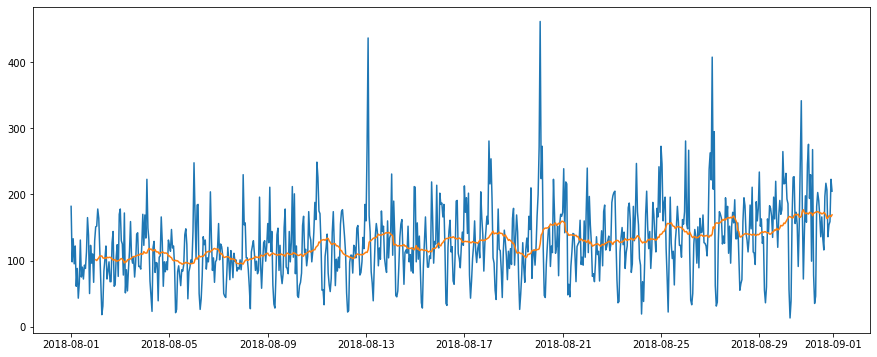

In [18]:
plt.plot(df_taxi['2018-08':]['num_orders'])
plt.plot(df_taxi['2018-08':]['num_orders'].shift().rolling(24).mean());

In [19]:
df_taxi['rolling'] = df_taxi['num_orders'].shift().rolling(24).mean()

In [20]:
df_taxi.head(3)

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,rolling
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Вывод:** данные были проанализированы, выделены параметры.

## Обучение

**Используемые функции**

In [21]:
def create_model(model_name: str, 
                 data: namedtuple = None, 
                 parametrs: dict = {},
                 cv: int=7,
                 scoring: str='neg_root_mean_squared_error',
                 **kwargs):
    
    #create model
    model = eval(model_name)(**kwargs)
    
    #use GridSearchCV
    tscv = TimeSeriesSplit(n_splits=cv)
    grid = GridSearchCV(model, parametrs, cv=tscv, scoring=scoring)
    grid.fit(data.features, data.target)
    
    return [model_name, 
            abs(grid.best_score_), 
            grid.best_params_, 
            grid.best_estimator_]

_________________________________

Разделим выборку на тренировочную и тестовые части, из тренировочной удалим записи с пропущенными значениями.

In [22]:
train = namedtuple('features','target')
test = namedtuple('features','target')
    
train.features, test.features, train.target, test.target = train_test_split(df_taxi.drop('num_orders',axis=1), 
                                                                                df_taxi['num_orders'], 
                                                                                test_size=0.1,  
                                                                                shuffle=False)

train.features.dropna(inplace=True)
train.target = train.target.loc[train.features.index]

print(f"Size of train {len(train.features)}, percentage of total {len(train.features)/len(df_taxi['num_orders']):.0%}")
print(f"Size of test {len(test.features)}, percentage of total {len(test.features)/len(df_taxi['num_orders']):.0%}\n") 
test.features.info()

Size of train 3950, percentage of total 89%
Size of test 442, percentage of total 10%

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 442 entries, 2018-08-13 14:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 26 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   dayofweek  442 non-null    int64  
 1   hour       442 non-null    int64  
 2   lag_1      442 non-null    float64
 3   lag_2      442 non-null    float64
 4   lag_3      442 non-null    float64
 5   lag_4      442 non-null    float64
 6   lag_5      442 non-null    float64
 7   lag_6      442 non-null    float64
 8   lag_7      442 non-null    float64
 9   lag_8      442 non-null    float64
 10  lag_9      442 non-null    float64
 11  lag_10     442 non-null    float64
 12  lag_11     442 non-null    float64
 13  lag_12     442 non-null    float64
 14  lag_13     442 non-null    float64
 15  lag_14     442 non-null    float64
 16  lag_15     442 non-null    float64
 17

In [23]:
models = []

___________________________
Будем использовать:
- LinearRegression
- RandomForestRegressor
- CatBoostRegressor

Для подбора гиперпараметров будем использовать GridSearchCV - нет необходимости выделять валидационную выборку. Подбор модели по метрике RMSE.

Для каждой модели будем брать небольшой набор гиперпараметров для экономии времени.

**Linear Regression**

In [24]:
%%time
models.append(create_model('LinearRegression', train))

CPU times: user 625 ms, sys: 814 ms, total: 1.44 s
Wall time: 1.91 s


**Random Forest**

In [25]:
%%time
rfr_params = {'max_depth': [2, 7, 11], 
              'min_samples_split': [10, 50],
              'n_estimators': [2, 10, 50],
              'random_state': [STATE]}

models.append(create_model('RandomForestRegressor', 
                           train,       
                           parametrs=rfr_params))

CPU times: user 40.2 s, sys: 0 ns, total: 40.2 s
Wall time: 4min 13s


**CatBoost**

In [26]:
%%time
cbr_params = {'learning_rate': [0.1,0.4], 
              'iterations': [50, 100],
              'random_state': [STATE],
              'verbose' : [100],
             }

models.append(create_model('CatBoostRegressor', 
                           train,  
                           parametrs=cbr_params))

0:	learn: 27.7618697	total: 302ms	remaining: 14.8s
49:	learn: 13.2100234	total: 1.76s	remaining: 0us
0:	learn: 28.2928806	total: 6.62ms	remaining: 324ms
49:	learn: 15.3861977	total: 1.91s	remaining: 0us
0:	learn: 29.7428877	total: 7.93ms	remaining: 389ms
49:	learn: 16.8609934	total: 1.6s	remaining: 0us
0:	learn: 30.6386603	total: 9.16ms	remaining: 449ms
49:	learn: 17.7863336	total: 2.7s	remaining: 0us
0:	learn: 31.5766369	total: 8.35ms	remaining: 409ms
49:	learn: 18.5110415	total: 1.75s	remaining: 0us
0:	learn: 32.5634808	total: 5.61ms	remaining: 275ms
49:	learn: 19.6225780	total: 1.39s	remaining: 0us
0:	learn: 34.2403755	total: 10.1ms	remaining: 496ms
49:	learn: 20.4818271	total: 1.56s	remaining: 0us
0:	learn: 24.4264441	total: 5.02ms	remaining: 246ms
49:	learn: 5.7451565	total: 964ms	remaining: 0us
0:	learn: 25.3532772	total: 5.39ms	remaining: 264ms
49:	learn: 7.9878918	total: 1.11s	remaining: 0us
0:	learn: 26.8624997	total: 63.4ms	remaining: 3.11s
49:	learn: 11.0502232	total: 1.1s	r

In [27]:
pd.DataFrame(models, columns=['Model', 'RMSE train', 'Hyperparams', 'Model'])

,Model,RMSE train,Hyperparams,Model
0,LinearRegression,26.827118,{},LinearRegression()
1,RandomForestRegressor,25.389773,"{'max_depth': 11, 'min_samples_split': 10, 'n_...","(DecisionTreeRegressor(max_depth=11, max_featu..."
2,CatBoostRegressor,25.090353,"{'iterations': 100, 'learning_rate': 0.1, 'ran...",<catboost.core.CatBoostRegressor object at 0x7...


**Вывод:** Для данных были построены модели. Лучшие результаты показала **CatBoostRegressor** с гиперпараметрами iterations=100 и learning_rate = 0.1.

## Тестирование

In [28]:
def model_test(test_data: namedtuple, model, period: str=None) -> float:
    #predict and index
    pred_ = model.predict(test_data.features)
    pred_ = pd.Series(pred_, index=test_data.target.index)
    
    #plots
    plt.plot(pred_[period:])
    plt.plot(test_data.target[period:])
    plt.legend(['predict','real'])
    plt.title('Real and prediction value')
    plt.show()
    
    #RMSE
    return mean_squared_error(pred_,test_data.target) ** .5

**CatBoost**

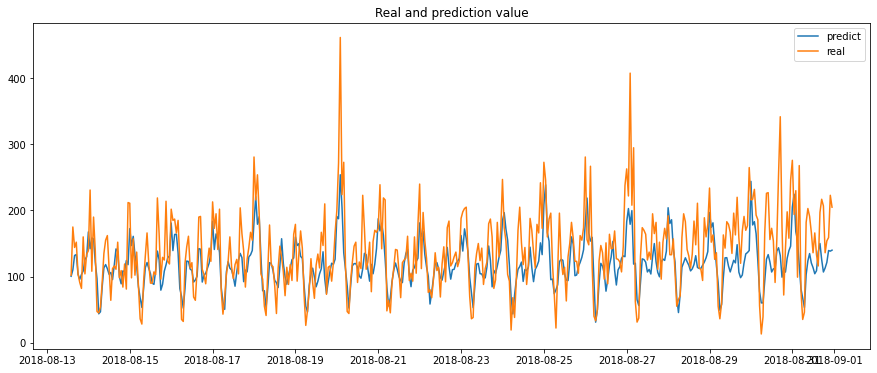

In [29]:
models[2].append(model_test(test, models[2][3]))

График выглядит похоже, но не учитывает "пики". Немного укрупним последние несколько дней:

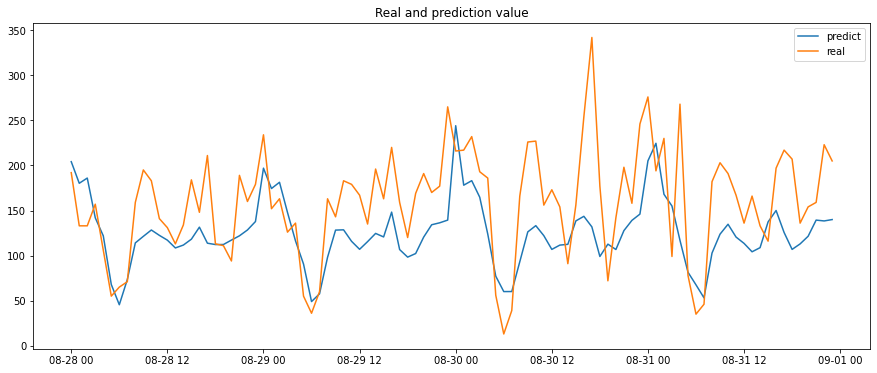

46.09753831457314

In [30]:
model_test(test, models[2][3], period='2018-08-28')

**Вывод:**

In [31]:
result = pd.DataFrame([models[2]], columns=['Model', 'RMSE train', 'Hyperparams', 'Model', 'RMSE test'])
result

,Model,RMSE train,Hyperparams,Model,RMSE test
0,CatBoostRegressor,25.090353,"{'iterations': 100, 'learning_rate': 0.1, 'ran...",<catboost.core.CatBoostRegressor object at 0x7...,46.097538


RMSE на тестовых значениях значительно больше, чем на оценка на тренировочных. <br>
Это не очень хорошо, и может говорить о том, что модель переобучилась. Но так же было отмечено, что в данных есть аномально большие значения, практически все которые приходятся на тестовую выборку. Подобные отклонения так же могут влиять на значение метрики, т.к. модель не может предсказать их.
Тем не менее, цель (RMSE < 48) достигнута для всех выбранных моделей.

## Вывод

Были получены и загружены данные. Т.к. требуется предсказание на час, было произведено ресеплирование по часу.

Данные были изучены, выделены значимые признаки.

Обучены модели:
- LinearRegression
- RandomForestRegressor
- CatBoostRegressor

с разным набором гиперпараметров и выбраны лучшие.

Из трех выбрана модель  **CatBoostRegressor** c гиперпараметрами iterations=100 и learning_rate = 0.1.


На тестовой выборке модель показала не очень хороший, но допустимый результат - 46.

In [32]:
result

,Model,RMSE train,Hyperparams,Model,RMSE test
0,CatBoostRegressor,25.090353,"{'iterations': 100, 'learning_rate': 0.1, 'ran...",<catboost.core.CatBoostRegressor object at 0x7...,46.097538
